
# Análise Comparativa de Modelos de Machine Learning
**Objetivo:** Comparar KNN, Decision Tree e Random Forest em dados desbalanceados vs. balanceados.

**Pré-processamento:** One-Hot apenas em nominais; Ordinais mantidas numéricas.

**Técnicas de Balanceamento:** Undersampling, Oversampling (SMOTE) e Híbrido (SMOTEENN).

In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos e Métricas
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Balanceamento
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Otimização Bayesiana
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings('ignore')

# --- 1. Carregamento e Preparação dos Dados ---

In [3]:
ARQUIVO_TREINO = '/content/sample_data/treinoDesbalanceado.csv'
ARQUIVO_TESTE = '/content/sample_data/teste.csv'
TARGET = 'DIABETES'

print("Carregando dados...")
df_train = pd.read_csv(ARQUIVO_TREINO)
df_test = pd.read_csv(ARQUIVO_TESTE)

# Preparação do Target (2 -> 0, 1 -> 1)
def preparar_target(df, target_col):
    df = df.dropna(subset=[target_col]).copy()
    df[target_col] = df[target_col].replace({2: 0})
    return df

df_train = preparar_target(df_train, TARGET)
df_test = preparar_target(df_test, TARGET)

Carregando dados...


# --- 2. Engenharia de Atributos (Encoding) ---






In [4]:
cols_nominais_onehot = ['TIPO_SUCO_INDUSTRIALIZADO', 'TIPO_REFRIGERANTE', 'TIPO_LEITE']
cols_binarias = ['SEXO', 'PLANO_SAUDE']

def aplicar_encoding(df):
    df_enc = df.copy()
    # Binárias (2 -> 0)
    for col in cols_binarias:
        if col in df_enc.columns:
            df_enc[col] = df_enc[col].replace({2: 0})
    # One-Hot
    df_enc = pd.get_dummies(df_enc, columns=cols_nominais_onehot, drop_first=False, dtype=int)
    return df_enc

df_train_proc = aplicar_encoding(df_train)
df_test_proc = aplicar_encoding(df_test)

# Alinhamento de colunas
df_train_proc, df_test_proc = df_train_proc.align(df_test_proc, join='left', axis=1, fill_value=0)

# Separação X/y
X_train = df_train_proc.drop(columns=[TARGET])
y_train = df_train_proc[TARGET]
X_test = df_test_proc.drop(columns=[TARGET])
y_test = df_test_proc[TARGET]

# --- 3. Normalização (Essencial para KNN) ---

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dados prontos. Shape Treino: {X_train_scaled.shape}")

Dados prontos. Shape Treino: (15864, 34)


# --- 4. Definição dos Espaços de busca (BayesSearch) ---

In [6]:
# Dicionário de Modelos Base
modelos_base = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Espaços de Hiperparâmetros para Otimização
search_spaces = {
    'KNN': {
        'n_neighbors': Integer(3, 30),
        'weights': Categorical(['uniform', 'distance']),
        'p': Integer(1, 2) # 1=Manhattan, 2=Euclidean
    },
    'Decision Tree': {
        'max_depth': [3, 5, 10, 15],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': Categorical(['gini', 'entropy'])
    },
    'Random Forest': {
        'n_estimators': [20, 30, 40, 60, 70, 90, 120, 150],
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10, 15],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
        'bootstrap': [True, False]
    }
}

tecnicas_balanceamento = {
    'Desbalanceado (Base)': None,
    'Undersampling': RandomUnderSampler(random_state=42),
    'Oversampling (SMOTE)': SMOTE(random_state=42),
    'Híbrido (SMOTEENN)': SMOTEENN(random_state=42)
}

resultados = []
matrizes_confusao = {}

# --- 5. Loop de Treinamento com Otimização ---

In [7]:
# Configuração do BayesSearch
N_ITER_BAYES = 15 # Número de tentativas de otimização por modelo (aumente se tiver tempo)
CV_FOLDS = 3      # Validação cruzada interna

print(f"Iniciando loop... (Isso pode demorar, pois rodará {N_ITER_BAYES} iterações de otimização para cada par modelo/técnica)")

for nome_tecnica, resampler in tecnicas_balanceamento.items():
    print(f"\n>>> TÉCNICA: {nome_tecnica}")

    # 1. Resampling
    if resampler:
        X_res, y_res = resampler.fit_resample(X_train_scaled, y_train)
    else:
        X_res, y_res = X_train_scaled, y_train

    print(f"    Shape Treino Resampled: {X_res.shape}")

    # 2. Otimização e Treino para cada Modelo
    for nome_modelo, modelo_base in modelos_base.items():
        print(f"    -> Otimizando {nome_modelo}...", end="")

        # Configurar Otimizador
        opt = BayesSearchCV(
            estimator=modelo_base,
            search_spaces=search_spaces[nome_modelo],
            n_iter=N_ITER_BAYES,
            cv=CV_FOLDS,
            n_jobs=-1, # Usa todos os cores
            random_state=42,
            scoring='f1' # Otimizar para F1-Score (melhor para classes desbalanceadas)
        )

        # Fit (Busca + Treino do melhor)
        opt.fit(X_res, y_res)

        print(f" Melhor F1 (CV): {opt.best_score_:.3f}")
        print(f"       Params: {dict(opt.best_params_)}")

        # Predição no Teste (Nunca visto)
        best_model = opt.best_estimator_
        y_pred = best_model.predict(X_test_scaled)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        resultados.append({
            'Técnica': nome_tecnica,
            'Modelo': nome_modelo,
            'Acurácia': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'Melhores Params': str(dict(opt.best_params_))
        })

        matrizes_confusao[f"{nome_modelo} - {nome_tecnica}"] = confusion_matrix(y_test, y_pred)

df_resultados = pd.DataFrame(resultados)

Iniciando loop... (Isso pode demorar, pois rodará 15 iterações de otimização para cada par modelo/técnica)

>>> TÉCNICA: Desbalanceado (Base)
    Shape Treino Resampled: (15864, 34)
    -> Otimizando KNN... Melhor F1 (CV): 0.360
       Params: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
    -> Otimizando Decision Tree... Melhor F1 (CV): 0.378
       Params: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 2}
    -> Otimizando Random Forest... Melhor F1 (CV): 0.362
       Params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 60}

>>> TÉCNICA: Undersampling
    Shape Treino Resampled: (6466, 34)
    -> Otimizando KNN... Melhor F1 (CV): 0.685
       Params: {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
    -> Otimizando Decision Tree... Melhor F1 (CV): 0.695
       Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_

#--- 5.1. Métricas ---


In [8]:
# --- Exibição Detalhada de Todas as Métricas por Abordagem ---

# Verifica se o treinamento já foi executado
if 'df_resultados' in locals():
    print("--- Relatório Completo de Performance (Todas as Abordagens) ---")

    # Definindo a ordem das colunas para visualização
    cols_view = ['Técnica', 'Modelo', 'Acurácia', 'Precision', 'Recall', 'F1-Score', 'Melhores Params']

    # Cria uma cópia para formatação
    df_view = df_resultados[cols_view].copy()

    # Formata os números para 4 casas decimais para facilitar a leitura
    for col in ['Acurácia', 'Precision', 'Recall', 'F1-Score']:
        df_view[col] = df_view[col].apply(lambda x: f"{x:.4f}")

    # Exibe a tabela completa ordenadada por Técnica para facilitar a comparação entre modelos dentro da mesma abordagem
    # Se estiver no Jupyter/Colab, o comando display() gera uma tabela formatada
    try:
        display(df_view.sort_values(by=['Técnica', 'Modelo']))
    except:
        print(df_view.sort_values(by=['Técnica', 'Modelo']).to_string())

    # (Opcional) Resumo estatístico por Técnica (Média dos modelos)
    print("\n--- Média de F1-Score por Técnica ---")
    print(df_resultados.groupby('Técnica')['F1-Score'].mean().sort_values(ascending=False))

else:
    print("⚠️ A tabela de resultados ainda não existe. Por favor, execute a célula de treinamento (Loop de Otimização) primeiro.")

--- Relatório Completo de Performance (Todas as Abordagens) ---


,Técnica,Modelo,Acurácia,Precision,Recall,F1-Score,Melhores Params
1,Desbalanceado (Base),Decision Tree,0.7773,0.4550,0.3121,0.3702,"{'criterion': 'gini', 'max_depth': 15, 'min_sa..."
0,Desbalanceado (Base),KNN,0.7764,0.4538,0.3240,0.3781,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}"
2,Desbalanceado (Base),Random Forest,0.7966,0.5291,0.2742,0.3612,"{'bootstrap': False, 'criterion': 'gini', 'max..."
10,Híbrido (SMOTEENN),Decision Tree,0.6507,0.3346,0.6732,0.4470,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
9,Híbrido (SMOTEENN),KNN,0.5451,0.2831,0.7630,0.4130,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}"
11,Híbrido (SMOTEENN),Random Forest,0.7092,0.3890,0.6774,0.4942,"{'bootstrap': False, 'criterion': 'entropy', '..."
7,Oversampling (SMOTE),Decision Tree,0.7279,0.3726,0.4348,0.4013,"{'criterion': 'gini', 'max_depth': 15, 'min_sa..."
6,Oversampling (SMOTE),KNN,0.6980,0.3483,0.5049,0.4123,"{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}"
8,Oversampling (SMOTE),Random Forest,0.7929,0.5076,0.4236,0.4618,"{'bootstrap': False, 'criterion': 'gini', 'max..."
4,Undersampling,Decision Tree,0.5810,0.3049,0.7798,0.4384,"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."



--- Média de F1-Score por Técnica ---
Técnica
Undersampling           0.469366
Híbrido (SMOTEENN)      0.451419
Oversampling (SMOTE)    0.425107
Desbalanceado (Base)    0.369829
Name: F1-Score, dtype: float64


# --- 6. Visualização: Comparação de Métricas ---


Gerando gráficos...


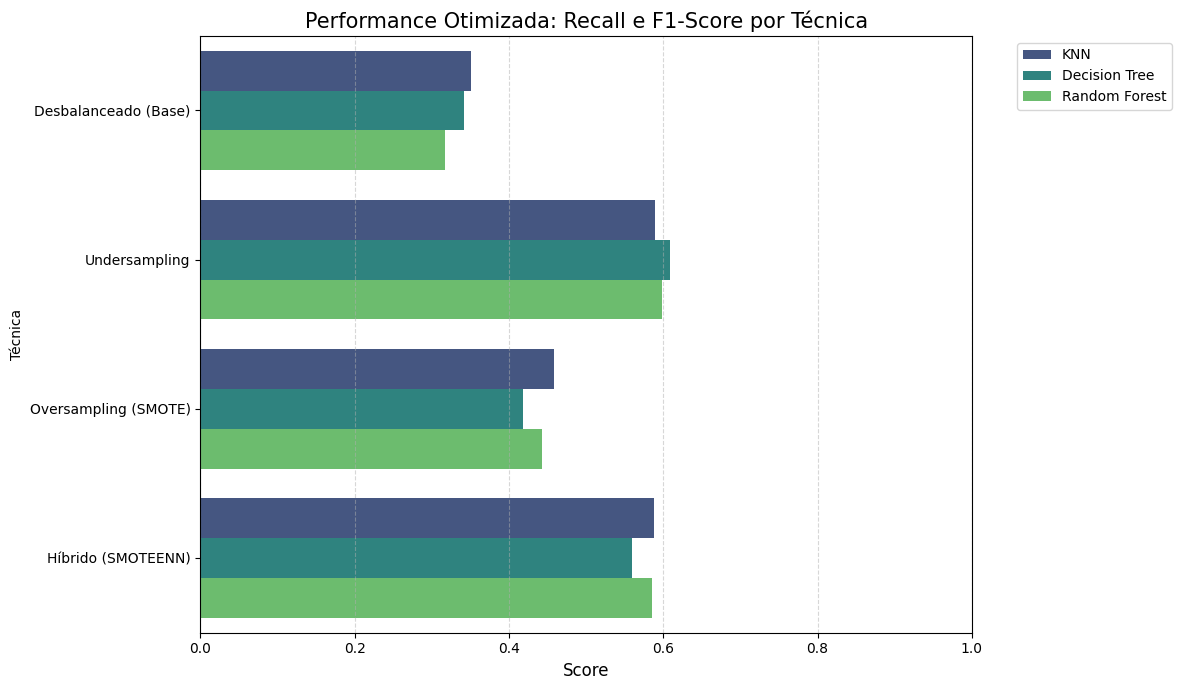


--- Ranking Final (Ordenado por F1-Score) ---
                 Técnica         Modelo    Recall  F1-Score  Acurácia
5          Undersampling  Random Forest  0.697055  0.499247  0.706722
11    Híbrido (SMOTEENN)  Random Forest  0.677419  0.494244  0.709222
3          Undersampling            KNN  0.708976  0.470451  0.665245
8   Oversampling (SMOTE)  Random Forest  0.423562  0.461774  0.792911
10    Híbrido (SMOTEENN)  Decision Tree  0.673212  0.447031  0.650684
4          Undersampling  Decision Tree  0.779804  0.438399  0.580968
9     Híbrido (SMOTEENN)            KNN  0.762973  0.412982  0.545080
6   Oversampling (SMOTE)            KNN  0.504909  0.412253  0.698044
7   Oversampling (SMOTE)  Decision Tree  0.434783  0.401294  0.727901
0   Desbalanceado (Base)            KNN  0.323983  0.378069  0.776438
1   Desbalanceado (Base)  Decision Tree  0.312062  0.370216  0.777320
2   Desbalanceado (Base)  Random Forest  0.274194  0.361201  0.796588


In [9]:
print("\nGerando gráficos...")

# Foco em Recall e F1-Score
df_melted = df_resultados.melt(id_vars=['Técnica', 'Modelo'],
                               value_vars=['Recall', 'F1-Score'],
                               var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 7))
sns.barplot(data=df_melted, x='Valor', y='Técnica', hue='Modelo', ci=None, palette='viridis')
plt.title('Performance Otimizada: Recall e F1-Score por Técnica', fontsize=15)
plt.xlabel('Score', fontsize=12)
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n--- Ranking Final (Ordenado por F1-Score) ---")
cols_show = ['Técnica', 'Modelo', 'Recall', 'F1-Score', 'Acurácia']
print(df_resultados.sort_values(by='F1-Score', ascending=False)[cols_show].to_string())

# --- 7. Visualização: Matrizes de Confusão ---

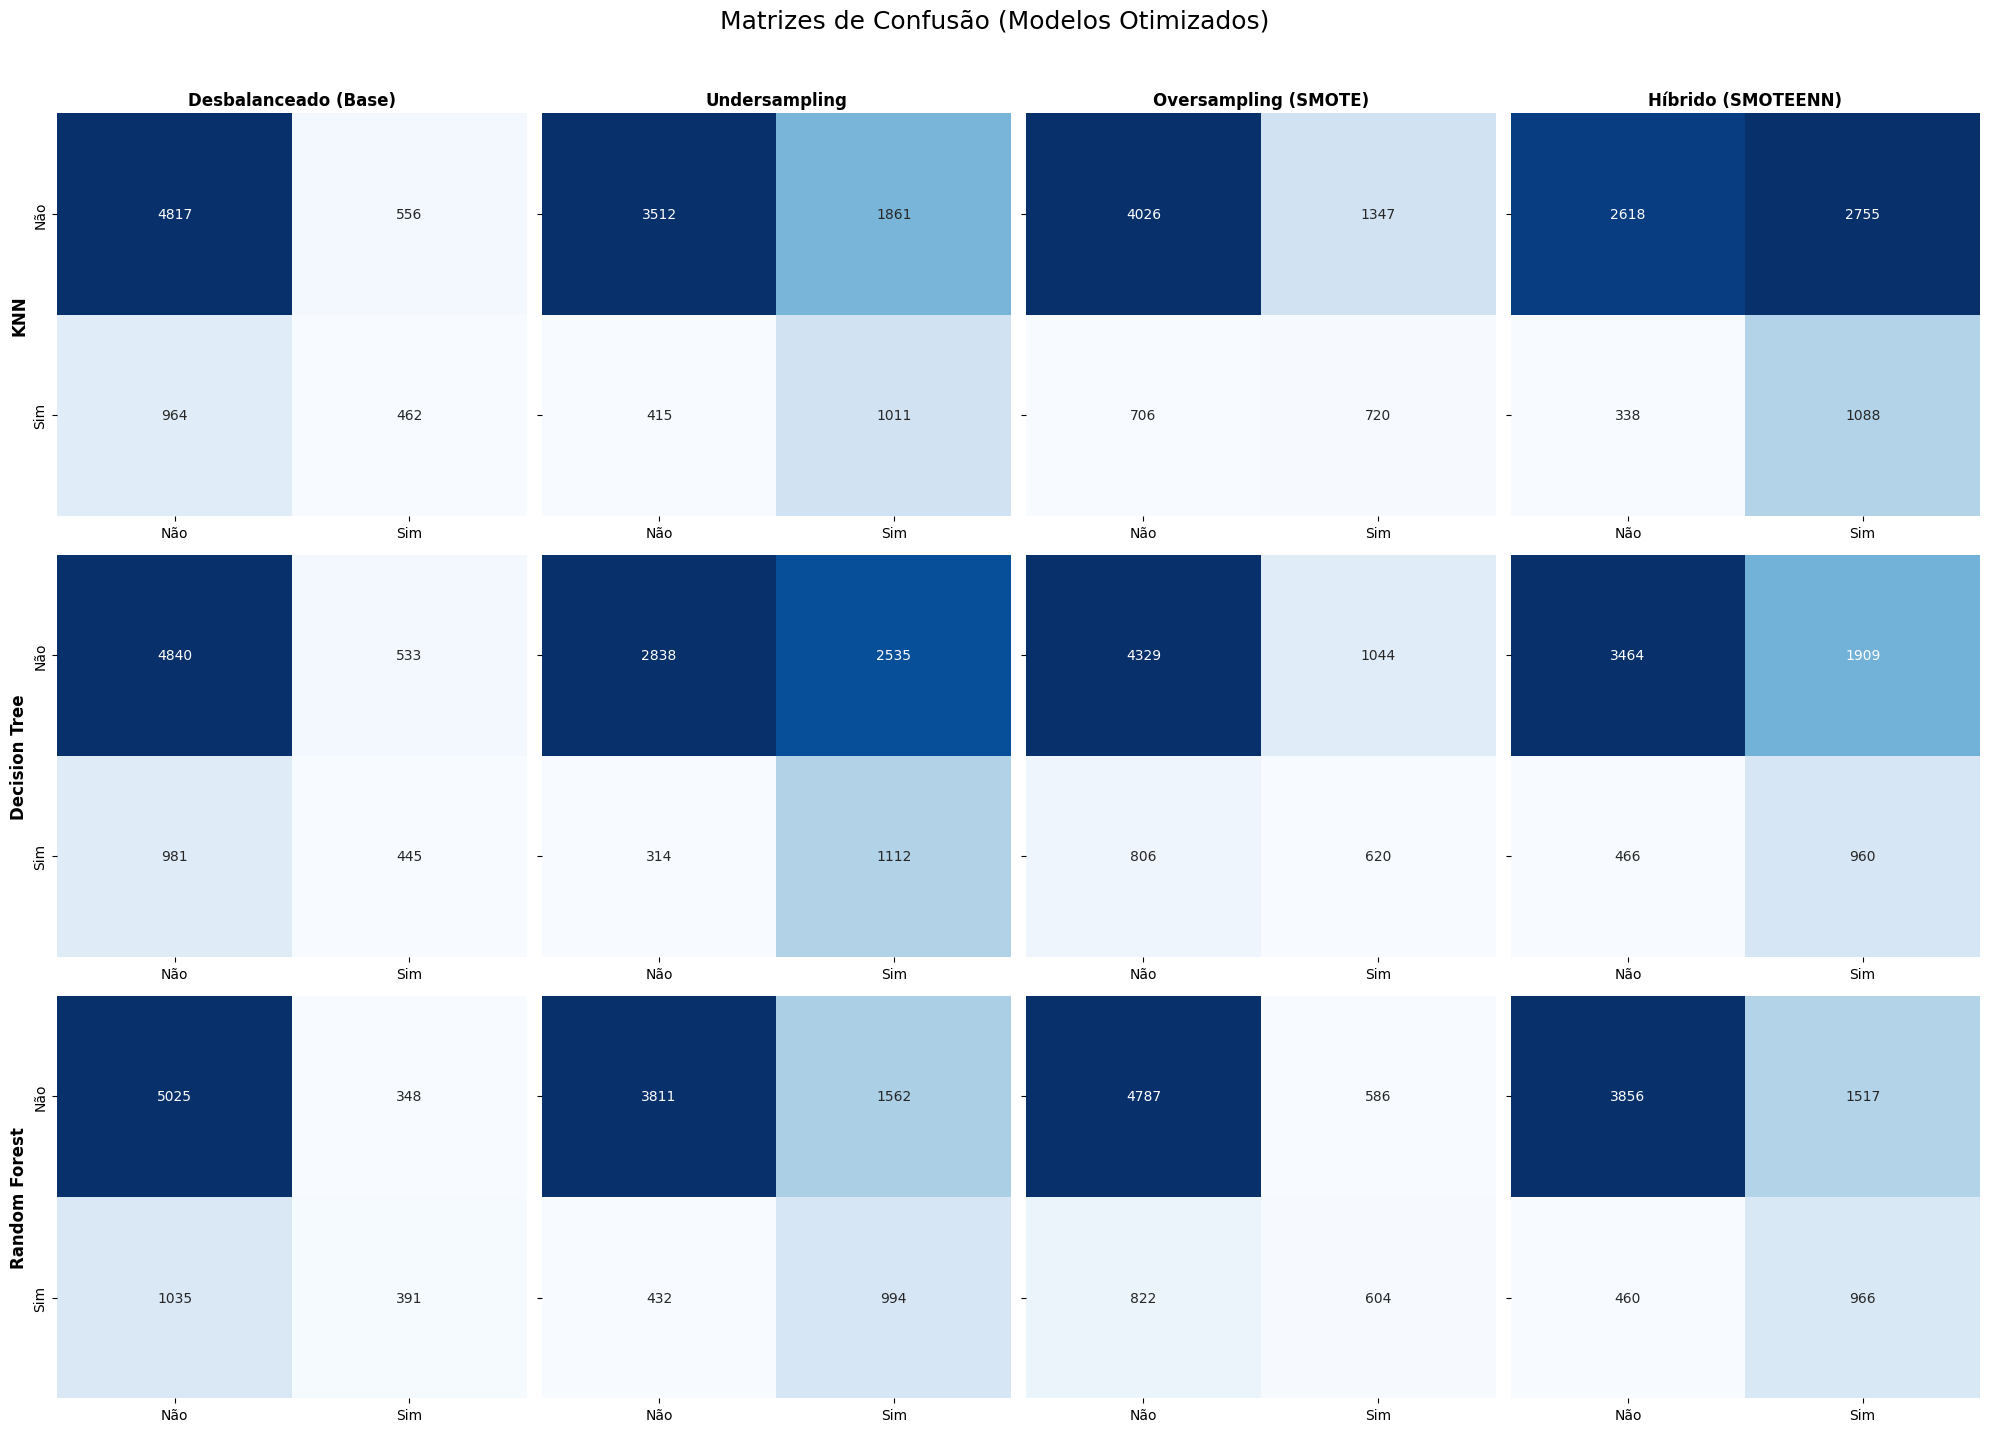

In [10]:
cols = 4
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 14))

lista_modelos = ['KNN', 'Decision Tree', 'Random Forest']
lista_tecnicas = list(tecnicas_balanceamento.keys())

for i, modelo in enumerate(lista_modelos):
    for j, tecnica in enumerate(lista_tecnicas):
        ax = axes[i, j]
        chave = f"{modelo} - {tecnica}"

        if chave in matrizes_confusao:
            cm = matrizes_confusao[chave]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

            if i == 0: ax.set_title(tecnica, fontweight='bold')
            if j == 0: ax.set_ylabel(modelo, fontweight='bold', fontsize=12)

            ax.set_xticklabels(['Não', 'Sim'])
            ax.set_yticklabels(['Não', 'Sim'] if j==0 else [])

plt.suptitle("Matrizes de Confusão (Modelos Otimizados)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

#---8. Gráficos---


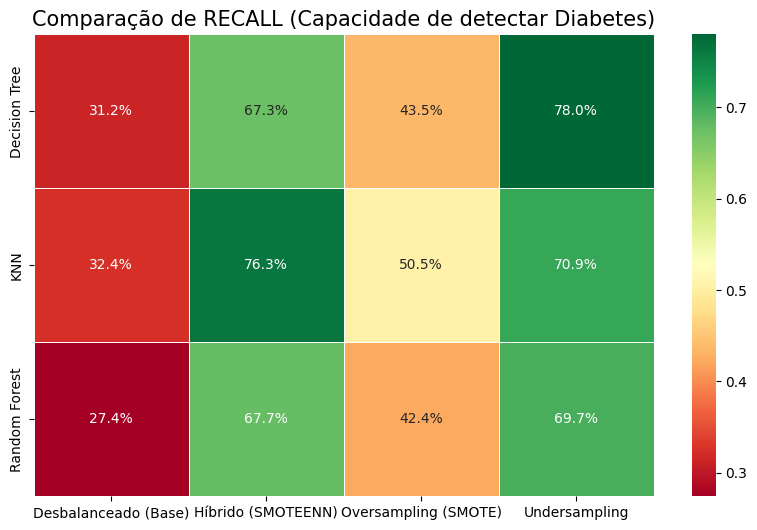

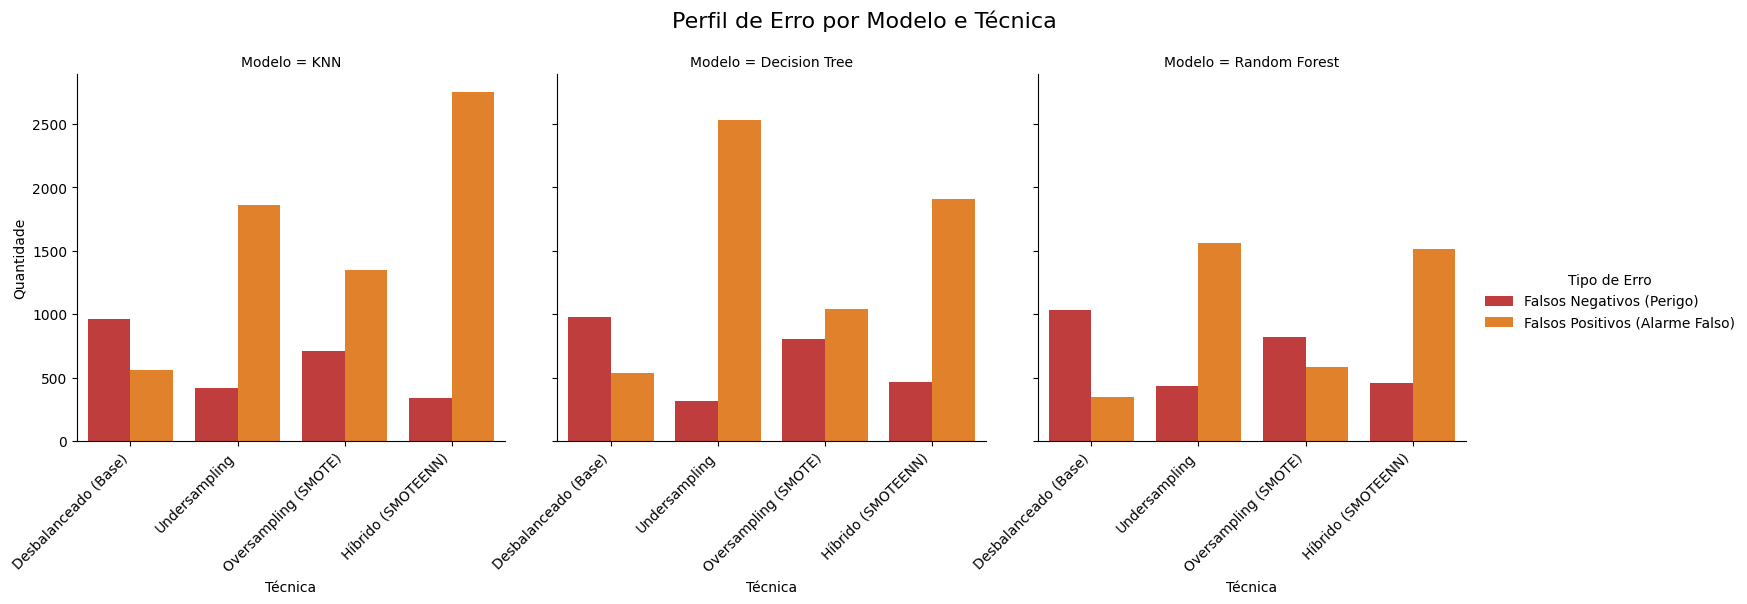

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Preparação dos Dados para Visualização ---
# Vamos extrair os erros das matrizes de confusão que salvamos anteriormente
erro_data = []

for chave, cm in matrizes_confusao.items():
    modelo, tecnica = chave.split(" - ")
    tn, fp, fn, tp = cm.ravel()

    erro_data.append({
        'Modelo': modelo,
        'Técnica': tecnica,
        'Falsos Negativos (Perigo)': fn,
        'Falsos Positivos (Alarme Falso)': fp,
        'Recall': tp / (tp + fn) # Recalculando só para garantir
    })

df_erros = pd.DataFrame(erro_data)

# --- VISUALIZAÇÃO 1: Heatmap de Recall (Onde acertamos os doentes?) ---
plt.figure(figsize=(10, 6))
pivot_recall = df_resultados.pivot(index='Modelo', columns='Técnica', values='Recall')

sns.heatmap(pivot_recall, annot=True, fmt=".1%", cmap='RdYlGn', linewidths=.5)
plt.title('Comparação de RECALL (Capacidade de detectar Diabetes)', fontsize=15)
plt.ylabel('')
plt.xlabel('')
plt.show()

# --- VISUALIZAÇÃO 2 AJUSTADA: Análise de Erros com Legenda Legível ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepara os dados novamente (caso a célula anterior tenha sido perdida)
erro_data = []
for chave, cm in matrizes_confusao.items():
    modelo, tecnica = chave.split(" - ")
    tn, fp, fn, tp = cm.ravel()
    erro_data.append({
        'Modelo': modelo,
        'Técnica': tecnica,
        'Falsos Negativos (Perigo)': fn,
        'Falsos Positivos (Alarme Falso)': fp
    })

df_melted_err = pd.DataFrame(erro_data).melt(
    id_vars=['Modelo', 'Técnica'],
    value_vars=['Falsos Negativos (Perigo)', 'Falsos Positivos (Alarme Falso)'],
    var_name='Tipo de Erro', value_name='Quantidade'
)

# Cria o gráfico facetado
g = sns.catplot(
    data=df_melted_err, kind="bar",
    x="Técnica", y="Quantidade", hue="Tipo de Erro", col="Modelo",
    palette={'Falsos Negativos (Perigo)': '#d62728', 'Falsos Positivos (Alarme Falso)': '#ff7f0e'},
    height=5, aspect=1, sharey=True
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Perfil de Erro por Modelo e Técnica', fontsize=16)

# --- AQUI ESTÁ A CORREÇÃO DA LEGENDA ---
g.set_xticklabels(rotation=45, ha='right')

plt.show()

#---9. Interpretação da árvores---


--- Aprofundando na Interpretabilidade dos Melhores Modelos ---

1. Melhor Random Forest encontrado usando: Undersampling
   (Retreinando para extrair importâncias...)


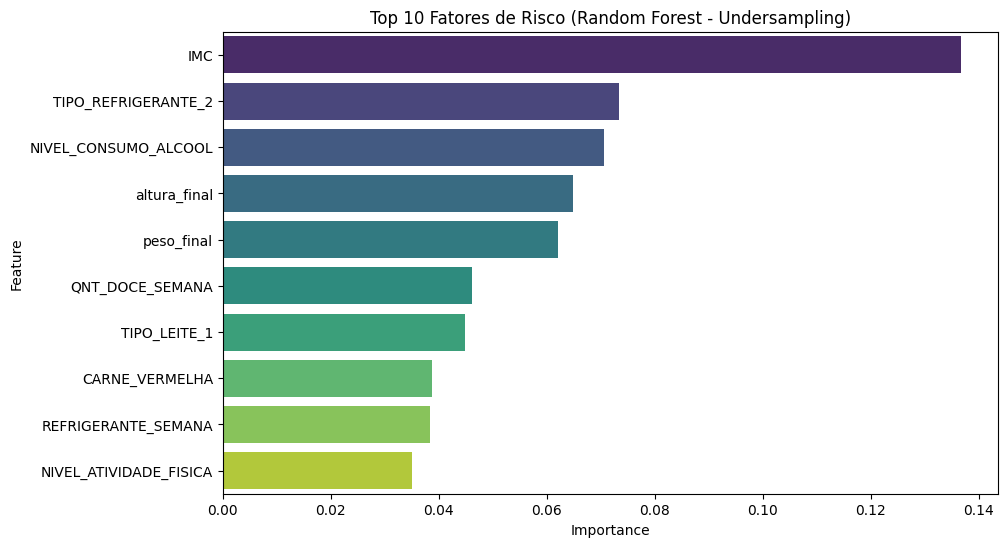


2. Melhor Decision Tree encontrada usando: Híbrido (SMOTEENN)
   (Visualizando as regras de decisão iniciais...)


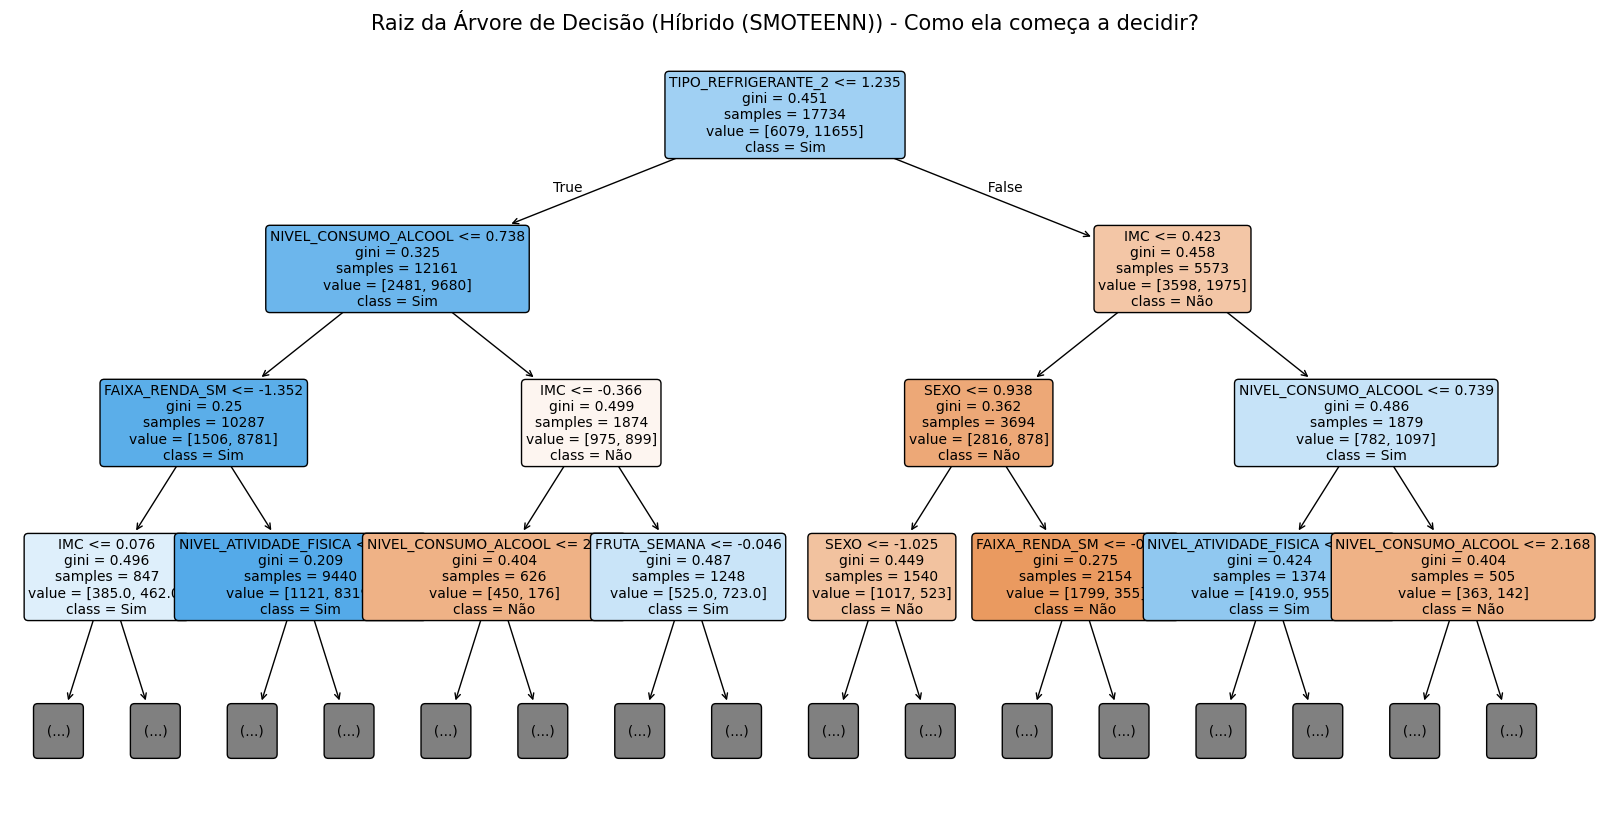

In [12]:
from sklearn.tree import plot_tree
import ast # Para ler o dicionário de parâmetros que ficou salvo como string

print("--- Aprofundando na Interpretabilidade dos Melhores Modelos ---\n")

# Recupera nomes das colunas originais (pós-encoding)
feature_names = X_train.columns

# ==============================================================================
# PARTE A: O que o Melhor RANDOM FOREST considerou importante?
# ==============================================================================

# 1. Encontrar o melhor RF na tabela de resultados
best_rf_row = df_resultados[df_resultados['Modelo'] == 'Random Forest'].sort_values(by='F1-Score', ascending=False).iloc[0]
tecnica_rf = best_rf_row['Técnica']
params_rf = ast.literal_eval(best_rf_row['Melhores Params']) # Converte string de volta para dict

print(f"1. Melhor Random Forest encontrado usando: {tecnica_rf}")
print(f"   (Retreinando para extrair importâncias...)")

# 2. Preparar dados com a técnica vencedora
X_res_rf, y_res_rf = X_train_scaled, y_train
if tecnica_rf != 'Desbalanceado (Base)':
    resampler = tecnicas_balanceamento[tecnica_rf]
    X_res_rf, y_res_rf = resampler.fit_resample(X_train_scaled, y_train)

# 3. Treinar Modelo
rf_final = RandomForestClassifier(**params_rf, random_state=42)
rf_final.fit(X_res_rf, y_res_rf)

# 4. Plotar Importância
importances = rf_final.feature_importances_
df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10) # Top 10

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top 10 Fatores de Risco (Random Forest - {tecnica_rf})')
plt.show()

# ==============================================================================
# PARTE B: As Raízes da Melhor DECISION TREE
# ==============================================================================

# 1. Encontrar a melhor Árvore
best_dt_row = df_resultados[df_resultados['Modelo'] == 'Decision Tree'].sort_values(by='F1-Score', ascending=False).iloc[0]
tecnica_dt = best_dt_row['Técnica']
params_dt = ast.literal_eval(best_dt_row['Melhores Params'])

print(f"\n2. Melhor Decision Tree encontrada usando: {tecnica_dt}")
print(f"   (Visualizando as regras de decisão iniciais...)")

# 2. Preparar dados
X_res_dt, y_res_dt = X_train_scaled, y_train
if tecnica_dt != 'Desbalanceado (Base)':
    resampler = tecnicas_balanceamento[tecnica_dt]
    X_res_dt, y_res_dt = resampler.fit_resample(X_train_scaled, y_train)

# 3. Treinar Modelo
dt_final = DecisionTreeClassifier(**params_dt, random_state=42)
dt_final.fit(X_res_dt, y_res_dt)

# 4. Plotar a Árvore (Limitando profundidade para facilitar leitura)
plt.figure(figsize=(20, 10))
plot_tree(dt_final,
          max_depth=3,                # Mostra apenas as 3 primeiras perguntas (Raízes)
          feature_names=feature_names,
          class_names=['Não', 'Sim'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f'Raiz da Árvore de Decisão ({tecnica_dt}) - Como ela começa a decidir?', fontsize=15)
plt.show()

# --- 10. Resumo Final Consolidado por Abordagem ---

In [14]:
import pandas as pd

print("====== RELATÓRIO DE PERFORMANCE POR ABORDAGEM ======\n")

# Colunas que queremos exibir
cols_show = ['Modelo', 'Acurácia', 'Precision', 'Recall', 'F1-Score']

# Tenta seguir a ordem de execução original, ou pega os únicos do dataframe
try:
    ordem_tecnicas = list(tecnicas_balanceamento.keys())
except NameError:
    ordem_tecnicas = df_resultados['Técnica'].unique()

for tecnica in ordem_tecnicas:
    # 1. Filtra os dados apenas da técnica atual
    # Verifica se a técnica existe no dataframe para evitar erros
    if tecnica in df_resultados['Técnica'].values:
        df_subset = df_resultados[df_resultados['Técnica'] == tecnica][cols_show].copy()

        # 2. Define o Modelo como índice (para ficar à esquerda, sem número de linha)
        df_subset.set_index('Modelo', inplace=True)

        # 3. Exibe o título e a tabela
        print(f"--- Abordagem: {tecnica} ---")

        try:
            # Se estiver no Jupyter/Colab, usa o style para formatar com 4 casas decimais
            display(df_subset.style.format("{:.4f}"))
        except:
            # Fallback para print normal caso o display não funcione
            print(df_subset.round(4))

        print("\n") # Espaço entre as tabelas

====== RELATÓRIO DE PERFORMANCE POR ABORDAGEM ======

--- Abordagem: Desbalanceado (Base) ---


,Acurácia,Precision,Recall,F1-Score
Modelo,,,,
KNN,0.7764,0.4538,0.3240,0.3781
Decision Tree,0.7773,0.4550,0.3121,0.3702
Random Forest,0.7966,0.5291,0.2742,0.3612




--- Abordagem: Undersampling ---


,Acurácia,Precision,Recall,F1-Score
Modelo,,,,
KNN,0.6652,0.3520,0.7090,0.4705
Decision Tree,0.5810,0.3049,0.7798,0.4384
Random Forest,0.7067,0.3889,0.6971,0.4992




--- Abordagem: Oversampling (SMOTE) ---


,Acurácia,Precision,Recall,F1-Score
Modelo,,,,
KNN,0.6980,0.3483,0.5049,0.4123
Decision Tree,0.7279,0.3726,0.4348,0.4013
Random Forest,0.7929,0.5076,0.4236,0.4618




--- Abordagem: Híbrido (SMOTEENN) ---


,Acurácia,Precision,Recall,F1-Score
Modelo,,,,
KNN,0.5451,0.2831,0.7630,0.4130
Decision Tree,0.6507,0.3346,0.6732,0.4470
Random Forest,0.7092,0.3890,0.6774,0.4942
